## Skeleton Code

The code below provides a skeleton for the model building & training component of your project. You can add/remove/build on code however you see fit, this is meant as a starting point.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt

##Import any other stats/DL/ML packages you may need here. E.g. Keras, scikit-learn, etc.
import sklearn.model_selection as skl
import tensorflow as tf
from itertools import chain
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import preprocess_input
from random import sample 
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16
from keras.applications.resnet import ResNet50 
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, plot_precision_recall_curve, f1_score, confusion_matrix

Using TensorFlow backend.


## Do some early processing of your metadata for easier model training:

In [2]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation
## Load the NIH data to all_xray_df
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
25991,00006830_000.png,No Finding,0,6830,52,M,PA,2500,2048,0.171,0.171,NaN,/data/images_004/images/00006830_000.png
40684,00010562_000.png,No Finding,0,10562,42,F,PA,2666,2163,0.143,0.143,NaN,/data/images_005/images/00010562_000.png
50005,00012655_000.png,Infiltration,0,12655,54,M,AP,2500,2048,0.168,0.168,NaN,/data/images_006/images/00012655_000.png


In [3]:
# create new df by splitting diagnoses column
all_xray_df_splitted = all_xray_df['Finding Labels'].str.split('\s*,\s*', expand=True).stack().str.get_dummies().sum(level=0)
# concatenate diagnoses df with original df
all_xray_df = pd.concat([all_xray_df, all_xray_df_splitted], axis = 1)

# drop "Unnamed: 11" column
all_xray_df = all_xray_df.drop('Unnamed: 11', 1)

all_xray_df.tail()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
112115,00030801_001.png,Mass|Pneumonia,1,30801,39,M,PA,2048,2500,0.168,...,0,0,0,0,1,0,0,0,1,0
112116,00030802_000.png,No Finding,0,30802,29,M,PA,2048,2500,0.168,...,0,0,0,0,0,1,0,0,0,0
112117,00030803_000.png,No Finding,0,30803,42,F,PA,2048,2500,0.168,...,0,0,0,0,0,1,0,0,0,0
112118,00030804_000.png,No Finding,0,30804,30,F,PA,2048,2500,0.168,...,0,0,0,0,0,1,0,0,0,0
112119,00030805_000.png,No Finding,0,30805,27,M,PA,2048,2500,0.171,...,0,0,0,0,0,1,0,0,0,0


In [4]:
## Here we create a new column called 'pneumonia_class' that will allow us to look at 
## images with or without pneumonia for binary classification

all_xray_df['pneumonia_class']=all_xray_df['Pneumonia']
all_xray_df['pneumonia_class']=all_xray_df['pneumonia_class'].replace(1.0,"yes_Pneumonia")
all_xray_df['pneumonia_class']=all_xray_df['pneumonia_class'].replace(0.0,"no_Pneumonia")

all_xray_df['pneumonia_class'].nunique()

2

In [5]:
all_xray_df['pneumonia_class']=all_xray_df['pneumonia_class'].replace({1:'pneumonia',0:'no_pneumonia'})

## Create your training and testing data:

In [6]:
def create_splits(df):
    
    ## Either build your own or use a built-in library to split your original dataframe into two sets 
    ## that can be used for training and testing your model
    ## It's important to consider here how balanced or imbalanced you want each of those sets to be
    ## for the presence of pneumonia
    
    # split the data into train and validation with 80-20 according to pneumonia_class
    train_data, val_data = skl.train_test_split(df, 
                                   test_size = 0.2, 
                                   stratify = df['pneumonia_class'])
    
    # correct the balance of the train_data to 50-50
    pneumonia_indx = train_data[train_data['pneumonia_class']=='pneumonia'].index.tolist()
    no_pneumonia_indx = train_data[train_data['pneumonia_class']=='no_pneumonia'].index.tolist()

    no_pneumonia_sample = sample(no_pneumonia_indx,len(pneumonia_indx))
    train_data = train_data.loc[pneumonia_indx + no_pneumonia_sample]
    
    # correct the balance in the validation according to the presence of pneumonia in this clinical situation
    pneumonia_indx = val_data[val_data['pneumonia_class']=='pneumonia'].index.tolist()
    no_pneumonia_indx = val_data[val_data['pneumonia_class']=='no_pneumonia'].index.tolist()

    no_pneumonia_sample = sample(no_pneumonia_indx,4*len(pneumonia_indx))
    val_data = val_data.loc[pneumonia_indx + no_pneumonia_sample]
    
    return train_data, val_data

In [7]:
x_train, x_val = create_splits(all_xray_df)

print ("Ratio of Pneumonia cases to total cases in training set: ",x_train['Pneumonia'].sum()/len(x_train))
print ("Ratio of Pneumonia cases to total cases in validation set: ",x_val['Pneumonia'].sum()/len(x_val))

Ratio of Pneumonia cases to total cases in training set:  0.5
Ratio of Pneumonia cases to total cases in validation set:  0.2


This ratios shows that we balanced training set correctly.

In [8]:
len(x_train), len(x_val)

(2290, 1430)

Lets look up to distribution of demographics:

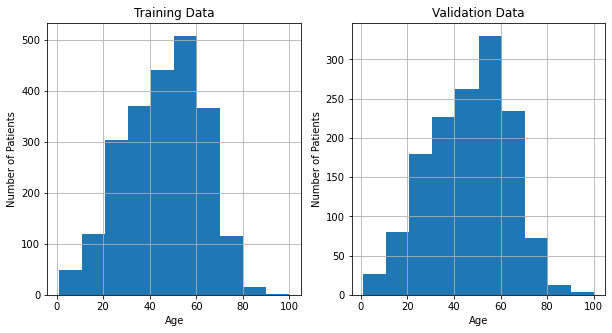

In [9]:
fig, ax = plt.subplots(1, 2, figsize = (10, 5))
ax[0].hist(x_train['Patient Age'],range=(1,100))
ax[0].set_xlabel("Age")
ax[0].set_title("Training Data")
ax[0].set_ylabel("Number of Patients")
ax[0].grid("on")

ax[1].hist(x_val['Patient Age'],range=(1,100))
ax[1].set_xlabel("Age")
ax[1].set_title("Validation Data")
ax[1].set_ylabel("Number of Patients")
ax[1].grid("on")

plt.show()

The distribution seems normal and balanced between two groups. Let's look at the min max age values for extreme values:

In [10]:
x_train['Patient Age'].describe(), x_val['Patient Age'].describe()

(count    2290.000000
 mean       46.178603
 std        18.689923
 min         2.000000
 25%        33.000000
 50%        48.000000
 75%        59.000000
 max       412.000000
 Name: Patient Age, dtype: float64,
 count    1430.000000
 mean       46.855944
 std        19.641723
 min         2.000000
 25%        33.000000
 50%        49.000000
 75%        59.000000
 max       412.000000
 Name: Patient Age, dtype: float64)

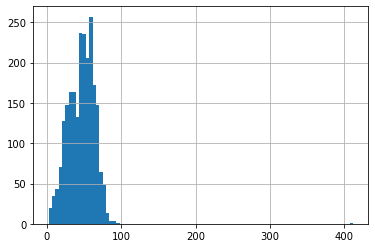

In [11]:
x_train['Patient Age'].hist(bins = x_train['Patient Age'].nunique())

As you can see, max age in validation group is 91 and in training group is 412. This is unrealistic. So let's delete this extreme ages more than 100. 

In [12]:
x_train = x_train[x_train['Patient Age'] <= 100]

In [13]:
len(x_train)

2289

We deleted one row that age was bigger than 100

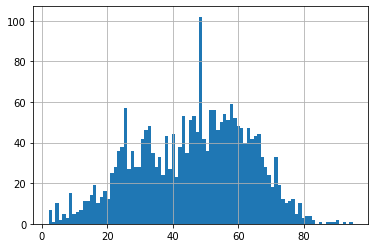

In [14]:
x_train['Patient Age'].hist(bins = x_train['Patient Age'].nunique())

# Now we can begin our model-building & training

#### First suggestion: perform some image augmentation on your data

In [15]:
def my_image_augmentation(mode="train"):
    # Implement Keras' ImageDataGenerator with some of the built-in augmentations 
    
    if mode == "train":
        my_idg = ImageDataGenerator(rescale=None,
                              preprocessing_function=preprocess_input,     
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range= 0.1, 
                              width_shift_range=0.1, 
                              rotation_range=20, 
                              shear_range = 0.2,
                              zoom_range=0.2)
    
    # Sort of training augmentation is or is not appropriate for testing vs validation data. 
    # So we augmentate them with different way.
    
    else :
        my_idg = ImageDataGenerator(rescale=None,
                                    preprocessing_function=preprocess_input
                                   )
    return my_idg

def make_train_gen(my_train_idg, train_df):
    # Create the actual generators using the output of my_image_augmentation for training data
    
    train_gen = my_train_idg.flow_from_dataframe(dataframe=train_df, 
                                         directory=None, 
                                         x_col = 'path',
                                         y_col = 'pneumonia_class',
                                         class_mode = 'binary',
                                         target_size = (224, 224),
                                         batch_size = 64
                                                 )
    return train_gen

def make_val_gen(my_val_idg, val_df):
    # Create the actual generators using the output of my_image_augmentation for validation data
    
    val_gen = my_val_idg.flow_from_dataframe(dataframe=val_df, 
                                        directory=None, 
                                        x_col = 'path',
                                        y_col = 'pneumonia_class',
                                        class_mode = 'binary',
                                        target_size = (224, 224),
                                        batch_size = 256
                                                )

    return val_gen

In [17]:
# Use data augmentation and generator functions
train_idg = my_image_augmentation()
val_idg = my_image_augmentation(mode="val")

train_gen = make_train_gen(train_idg,x_train)
val_gen = make_val_gen(val_idg,x_val)

Found 2289 validated image filenames belonging to 2 classes.
Found 1430 validated image filenames belonging to 2 classes.


In [18]:
# want to pull a single large batch of random validation data for testing after each epoch:
valX, valY = val_gen.next()

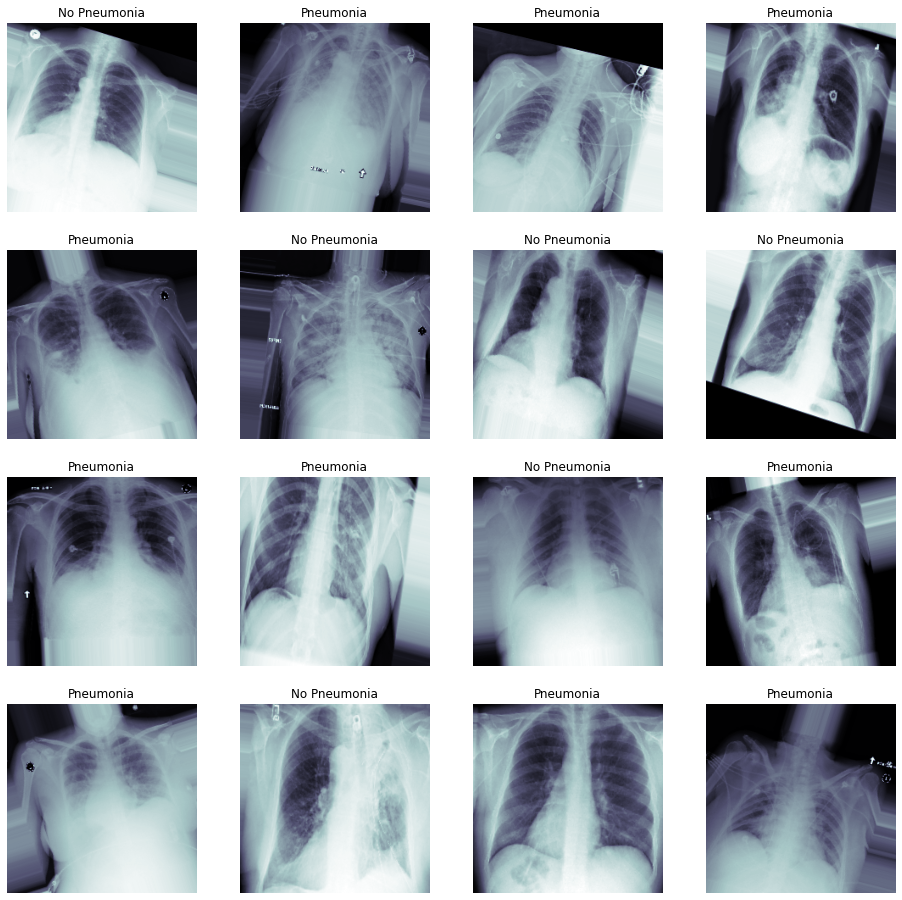

In [19]:
## Let's look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation

t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

## Build your model: 

Recommendation here to use a pre-trained network downloaded from Keras for fine-tuning

In [20]:
def load_pretrained_model():
    
    # load vgg16 model that pretrained on imagenet dataset
    model = VGG16(include_top=True, weights='imagenet')
    transfer_layer = model.get_layer('block5_pool')
    vgg_model = Model(inputs=model.input,outputs=transfer_layer.output)
    
    return vgg_model

In [21]:
def build_my_model(vgg_model):
    
    for layer in vgg_model.layers:
        layer.trainable = False

    my_model = Sequential()
    my_model.add(vgg_model)
    my_model.add(Flatten())

    # Add a dense (aka. fully-connected) layer.
    # This is for combining features that the VGG16 model has recognized in the image.
    my_model.add(Dense(4096, activation='relu'))
    my_model.add(Dropout(0.6))
    my_model.add(Dense(128, activation='relu'))
    my_model.add(Dropout(0.5))
    my_model.add(Dense(1, activation='sigmoid'))
    
    #set optimizer, loss function, and metrics to monitor
    optimizer = Adam(lr=5e-5)
    loss = 'binary_crossentropy'
    metrics = ['binary_accuracy']
    
    my_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    return my_model


In [22]:
# Add checkpoints to your model,
# This will save the 'best' version of the model by comparing it to previous epochs of training

# Note that you need to choose which metric to monitor for your model's 'best' performance if using this code. 
# The 'patience' parameter meaning that your model will train for how many epochs without seeing improvement before quitting.

weight_path="{}_my_model.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, 
                              monitor= 'loss', 
                              verbose=1, 
                              save_best_only=True, 
                              mode= 'min', 
                              save_weights_only = True)

early = EarlyStopping(monitor='loss', 
                       mode='min', 
                       patience=10)

callbacks_list = [checkpoint, early]

### Start training! 

In [23]:
# Build model for training by described functions before
my_vgg = load_pretrained_model()
my_model = build_my_model(my_vgg)

553467904/553467096 [==============================] - 9s 0us/step


In [24]:
my_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Model)              (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 4096)              102764544 
_________________________________________________________________
dropout_1 (Dropout)          (None, 4096)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               524416    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

You can see our added layers to model structure before.

In [25]:
# Train the model
history = my_model.fit_generator(train_gen, 
                           validation_data = (valX, valY), 
                           epochs = 90, 
                           callbacks = callbacks_list)


Epoch 1/90
36/36 [==============================] - 73s 2s/step - loss: 3.4180 - binary_accuracy: 0.5076 - val_loss: 0.7118 - val_binary_accuracy: 0.5000

Epoch 00001: loss improved from inf to 3.40664, saving model to xray_class_my_model.best.hdf5
Epoch 2/90
36/36 [==============================] - 63s 2s/step - loss: 1.0047 - binary_accuracy: 0.5387 - val_loss: 0.6649 - val_binary_accuracy: 0.6836

Epoch 00002: loss improved from 3.40664 to 1.00391, saving model to xray_class_my_model.best.hdf5
Epoch 3/90
36/36 [==============================] - 62s 2s/step - loss: 0.8153 - binary_accuracy: 0.5321 - val_loss: 0.6830 - val_binary_accuracy: 0.6914

Epoch 00003: loss improved from 1.00391 to 0.81597, saving model to xray_class_my_model.best.hdf5
Epoch 4/90
36/36 [==============================] - 61s 2s/step - loss: 0.7671 - binary_accuracy: 0.5177 - val_loss: 0.6912 - val_binary_accuracy: 0.5234

Epoch 00004: loss improved from 0.81597 to 0.76726, saving model to xray_class_my_model.be


Epoch 00036: loss improved from 0.66096 to 0.65337, saving model to xray_class_my_model.best.hdf5
Epoch 37/90
36/36 [==============================] - 57s 2s/step - loss: 0.6676 - binary_accuracy: 0.6125 - val_loss: 0.6456 - val_binary_accuracy: 0.6484

Epoch 00037: loss did not improve from 0.65337
Epoch 38/90
36/36 [==============================] - 57s 2s/step - loss: 0.6601 - binary_accuracy: 0.6007 - val_loss: 0.6523 - val_binary_accuracy: 0.6094

Epoch 00038: loss did not improve from 0.65337
Epoch 39/90
36/36 [==============================] - 58s 2s/step - loss: 0.6548 - binary_accuracy: 0.6282 - val_loss: 0.6690 - val_binary_accuracy: 0.5898

Epoch 00039: loss did not improve from 0.65337
Epoch 40/90
36/36 [==============================] - 58s 2s/step - loss: 0.6492 - binary_accuracy: 0.6221 - val_loss: 0.6481 - val_binary_accuracy: 0.6172

Epoch 00040: loss improved from 0.65337 to 0.64890, saving model to xray_class_my_model.best.hdf5
Epoch 41/90
36/36 [===================

36/36 [==============================] - 58s 2s/step - loss: 0.6171 - binary_accuracy: 0.6597 - val_loss: 0.6963 - val_binary_accuracy: 0.5508

Epoch 00075: loss did not improve from 0.61342
Epoch 76/90
36/36 [==============================] - 57s 2s/step - loss: 0.6135 - binary_accuracy: 0.6579 - val_loss: 0.6360 - val_binary_accuracy: 0.6055

Epoch 00076: loss improved from 0.61342 to 0.61274, saving model to xray_class_my_model.best.hdf5
Epoch 77/90
36/36 [==============================] - 58s 2s/step - loss: 0.6088 - binary_accuracy: 0.6745 - val_loss: 0.6516 - val_binary_accuracy: 0.5977

Epoch 00077: loss improved from 0.61274 to 0.60844, saving model to xray_class_my_model.best.hdf5
Epoch 78/90
36/36 [==============================] - 59s 2s/step - loss: 0.6142 - binary_accuracy: 0.6557 - val_loss: 0.6473 - val_binary_accuracy: 0.5977

Epoch 00078: loss did not improve from 0.60844
Epoch 79/90
36/36 [==============================] - 57s 2s/step - loss: 0.6111 - binary_accuracy:

##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

In [27]:
# Make some predictions to assess the model's overall performance
# Note that detecting pneumonia is hard even for trained expert radiologists, so there is no need to make the model perfect.

my_model.load_weights(weight_path)
pred_Y = my_model.predict(valX, batch_size = 32, verbose = True)

256/256 [==============================] - 6s 22ms/step


In [28]:
def plot_auc(t_y, p_y):
    
    fig, c_ax = plt.subplots(1,1, figsize = (5, 5))
    fpr, tpr, thresholds = roc_curve(t_y, p_y)
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % ('Pneumonia', auc(fpr, tpr)))
    c_ax.legend()
    c_ax.set_xlabel('False Positive Rate')
    c_ax.set_ylabel('True Positive Rate')
    
    return

def plot_precision_recall_curve(t_y, p_y):
    fig, c_ax = plt.subplots(1,1, figsize = (5, 5))
    precision, recall, thresholds = precision_recall_curve(t_y, p_y)
    c_ax.plot(recall, precision, label = '%s (AP Score:%0.2f)'  % ('Pneumonia', average_precision_score(t_y,p_y)))
    c_ax.legend()
    c_ax.set_xlabel('Recall')
    c_ax.set_ylabel('Precision')
                    
def  calc_f1(prec,recall):
    # calculate f1-score via precision and recall metrics.
    return 2*(prec*recall)/(prec+recall)
    
# Plotting the history of the model training:

def plot_history(history):

    loss = history.history['loss']
    vloss= history.history['val_loss']
    fig, c_ax = plt.subplots(1,1, figsize = (5, 5))
    c_ax.plot(range(len(loss)), loss,label="Training loss",c='r')
    c_ax.plot(range(len(vloss)), vloss,label="Val loss loss",c='b')
    c_ax.legend()
    c_ax.set_xlabel('Epoch')
    c_ax.set_ylabel(' Loss')

Epoch count:90


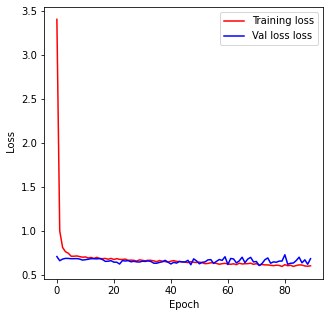

In [31]:
## plot figures

print ("Epoch count:" + str(len(history.history['loss'])))
plot_history(history)

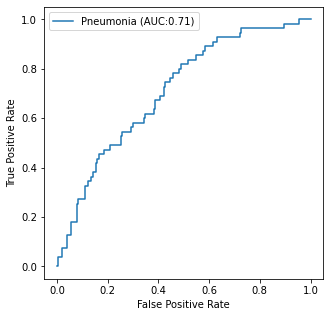

In [32]:
plot_auc(valY, pred_Y)

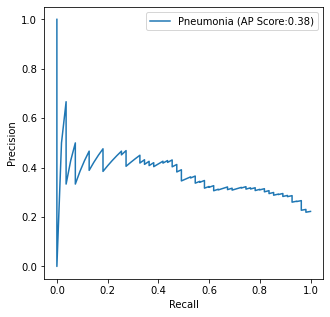

In [33]:
plot_precision_recall_curve(valY, pred_Y)

Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide) 

In [34]:
# Find the threshold that optimize the model's performance by recall value.
# We will use that threshold to make binary classification. Make sure you take all your metrics into consideration.

precision, recall, thresholds = precision_recall_curve(valY,pred_Y)

recall_value = 0.75
idx = (np.abs(recall - recall_value)).argmin() 
print('Precision is: '+ str(precision[idx]))
print('Recall is: '+ str(recall[idx]))
print('Threshold is: '+ str(thresholds[idx]))
print('F1 Score is: ' + str(calc_f1(precision[idx],recall[idx])))

Precision is: 0.31297709923664124
Recall is: 0.7454545454545455
Threshold is: 0.50120884
F1 Score is: 0.44086021505376344


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars


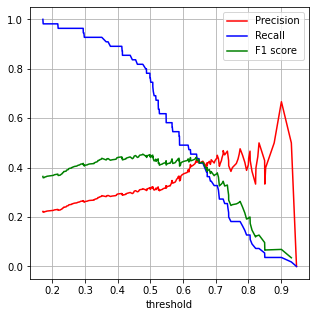

In [35]:
# Visualize presicion, recall, f1 score values by threshold

f1sc=[]
for p,r in zip(precision[:-1],recall[:-1]):
    f1sc.append(calc_f1(p,r))


fig, c_ax = plt.subplots(1,1, figsize = (5, 5))
c_ax.plot(thresholds, precision[:-1],label="Precision",c='r')
c_ax.plot(thresholds, recall[:-1],label="Recall",c='b')
c_ax.plot(thresholds, f1sc,label="F1 score",c='g')
c_ax.legend()
c_ax.set_xlabel('threshold')
plt.grid("on")

From the above we can observe we achieve a maximum F1 score of 0.4 when the treshold is 0.35, this is slightly higher to the average of radiologists 0.387 according to the CheXNet paper.

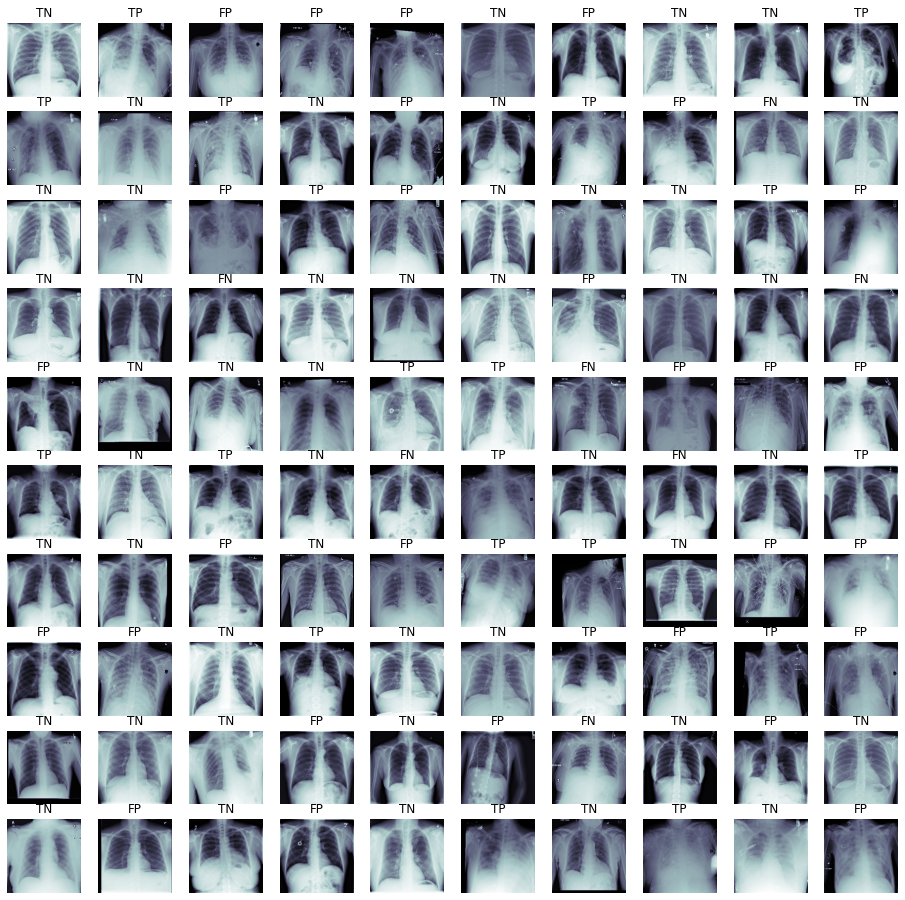

In [38]:
# Let's look at some examples of true vs. predicted with our best model: 
experimental_threshold = thresholds[idx]

fig, m_axs = plt.subplots(10, 10, figsize = (16, 16))
i = 0

for (c_x, c_y, c_ax) in zip(valX[0:100], valY[0:100], m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        if pred_Y[i] > experimental_threshold:
            c_ax.set_title('TP')
        else:
            c_ax.set_title('FN')
    else:
        if pred_Y[i] > experimental_threshold: 
            c_ax.set_title('FP')
        else:
            c_ax.set_title('TN')
    c_ax.axis('off')
    i=i+1

In [39]:
## Just save model architecture to a .json:

model_json = my_model.to_json()
with open("my_model.json", "w") as json_file:
    json_file.write(model_json)